#### First we are installing Kaggle to import dataset from it.

### Importing Libraires

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from scipy import optimize, stats, linalg, ndimage

In [2]:
# Constant values that we are going to use 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #RGB
EPOCHS = 20 

### Exploratory Data Analysis.

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle="True",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
# Classes which are present in the dataset as a folder name
class_names = dataset.class_names
print(class_names)

['Early_blight', 'Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 1 1 0 2 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 2]


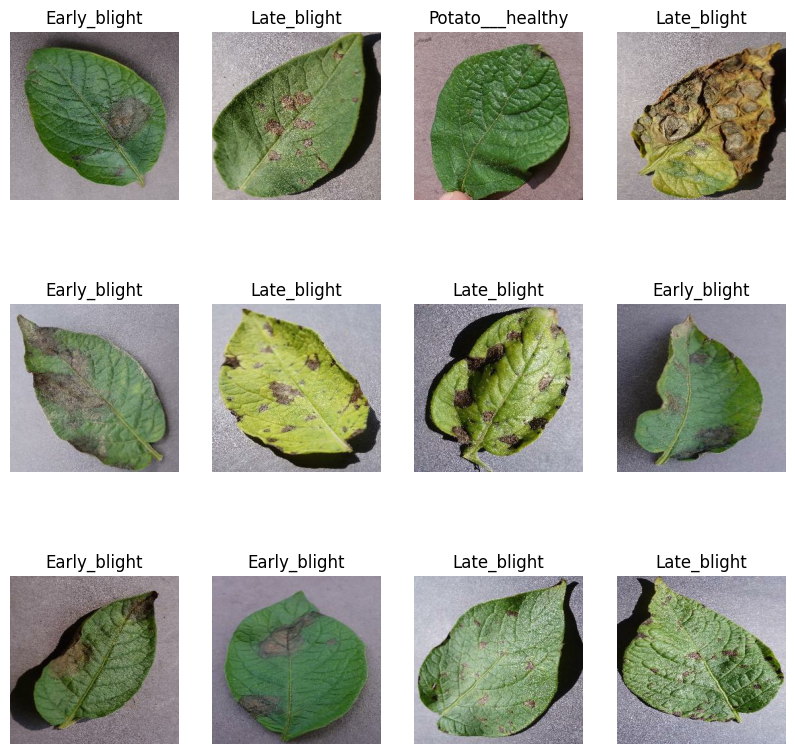

In [8]:
# Some images of both the diseases
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(0,12):
    ax = plt.subplot(3,4,i+1)
    plt.title(class_names[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

# Data Preparation and Model Training:

## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

### Data Augmentation 
Data Augmentation is needed when we have less data or when we want to make our model robust, we do this to boost the accuracy of our model.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
#         save_to_dir="training\\AugmentedImages"
)

Found 1721 images belonging to 3 classes.


In [8]:
train_generator.class_indices


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [9]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [10]:
validation_datagen = ImageDataGenerator(
        rescale=1./255, #it will try to normalise pixel values 
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.


In [11]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 216 images belonging to 3 classes.


 ### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model.build() is not needed, but if you want to use it:
# model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model.summary()


c:\Users\Rushikesh\Downloads\Harshikesh\Project\env\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=57,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=20,
)

c:\Users\Rushikesh\Downloads\Harshikesh\Project\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
54/57 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4706 - loss: 0.9398

c:\Users\Rushikesh\Downloads\Harshikesh\Project\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4711 - loss: 0.9372 - val_accuracy: 0.6406 - val_loss: 0.8506
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - accuracy: 0.5942 - loss: 0.7874 - val_accuracy: 0.7188 - val_loss: 0.6060
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 691ms/step - accuracy: 0.7422 - loss: 0.5675 - val_accuracy: 0.7917 - val_loss: 0.4825
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 694ms/step - accuracy: 0.8226 - loss: 0.4114 - val_accuracy: 0.8177 - val_loss: 0.4917
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 689ms/step - accuracy: 0.8382 - loss: 0.3790 - val_accuracy: 0.8802 - val_loss: 0.3308
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 685ms/step - accuracy: 0.8829 - loss: 0.2748 - val_accuracy: 0.9010 - val_loss: 0.2344
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 676ms/step - accuracy: 0.9179 - loss: 0.1855 - val_accuracy: 0.8958 - val_loss: 0.2640
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - accuracy: 0.9154 - loss: 0.1992 - val_accuracy: 0.9167 

In [17]:
scores = model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.9551 - loss: 0.1728


In [18]:
scores

[0.13090530037879944, 0.9583333134651184]

**Scores is just a list containing loss and accuracy value**

## Plotting the Accuracy and Loss Curve

In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 57}

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

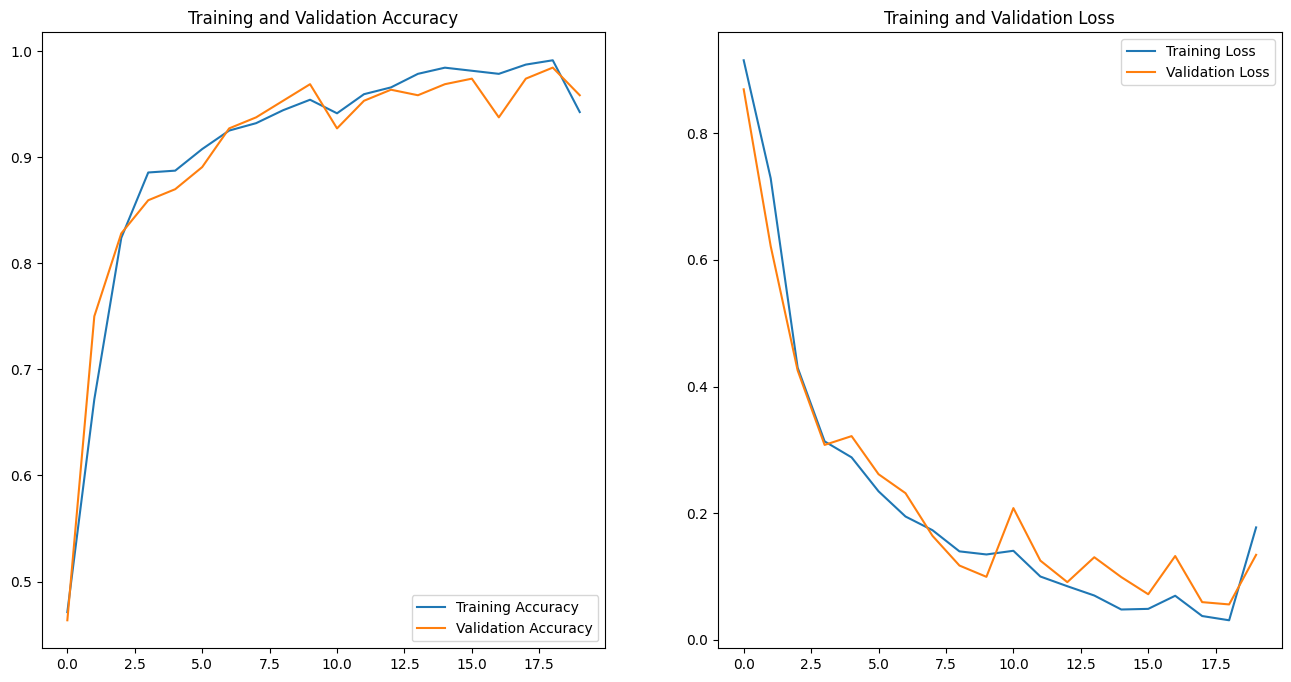

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

C:\Users\Rushikesh\AppData\Local\Temp\ipykernel_21316\154345153.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([acc, val_acc],


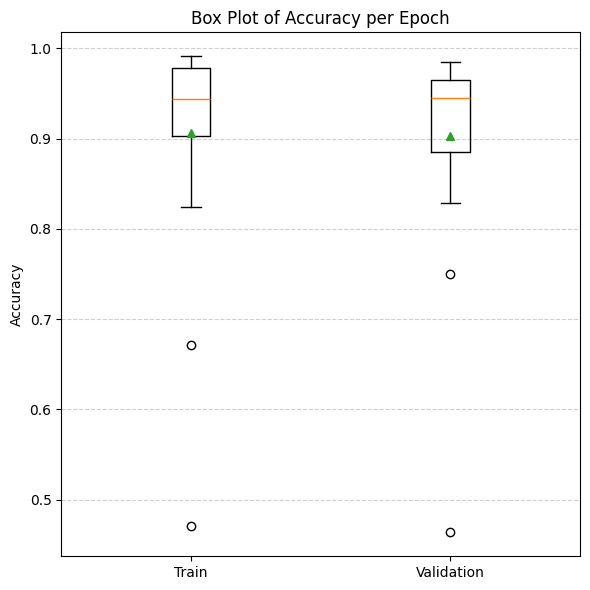

In [25]:
# Box-and-Whisker Plot for Accuracy with Outlier Detection
plt.figure(figsize=(6, 6))
plt.boxplot([acc, val_acc],
            labels=['Train', 'Validation'],
            showfliers=True,
            showmeans=True)
plt.title('Box Plot of Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
predicted label: Potato___Early_blight


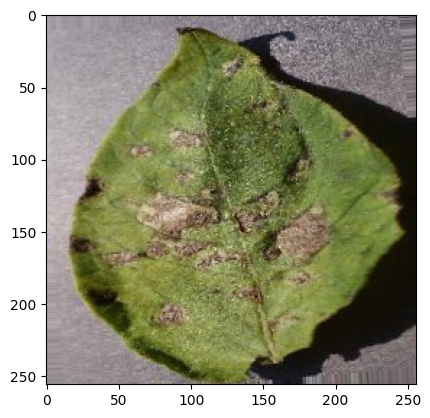

In [26]:
import numpy as np


for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

# function for inference

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


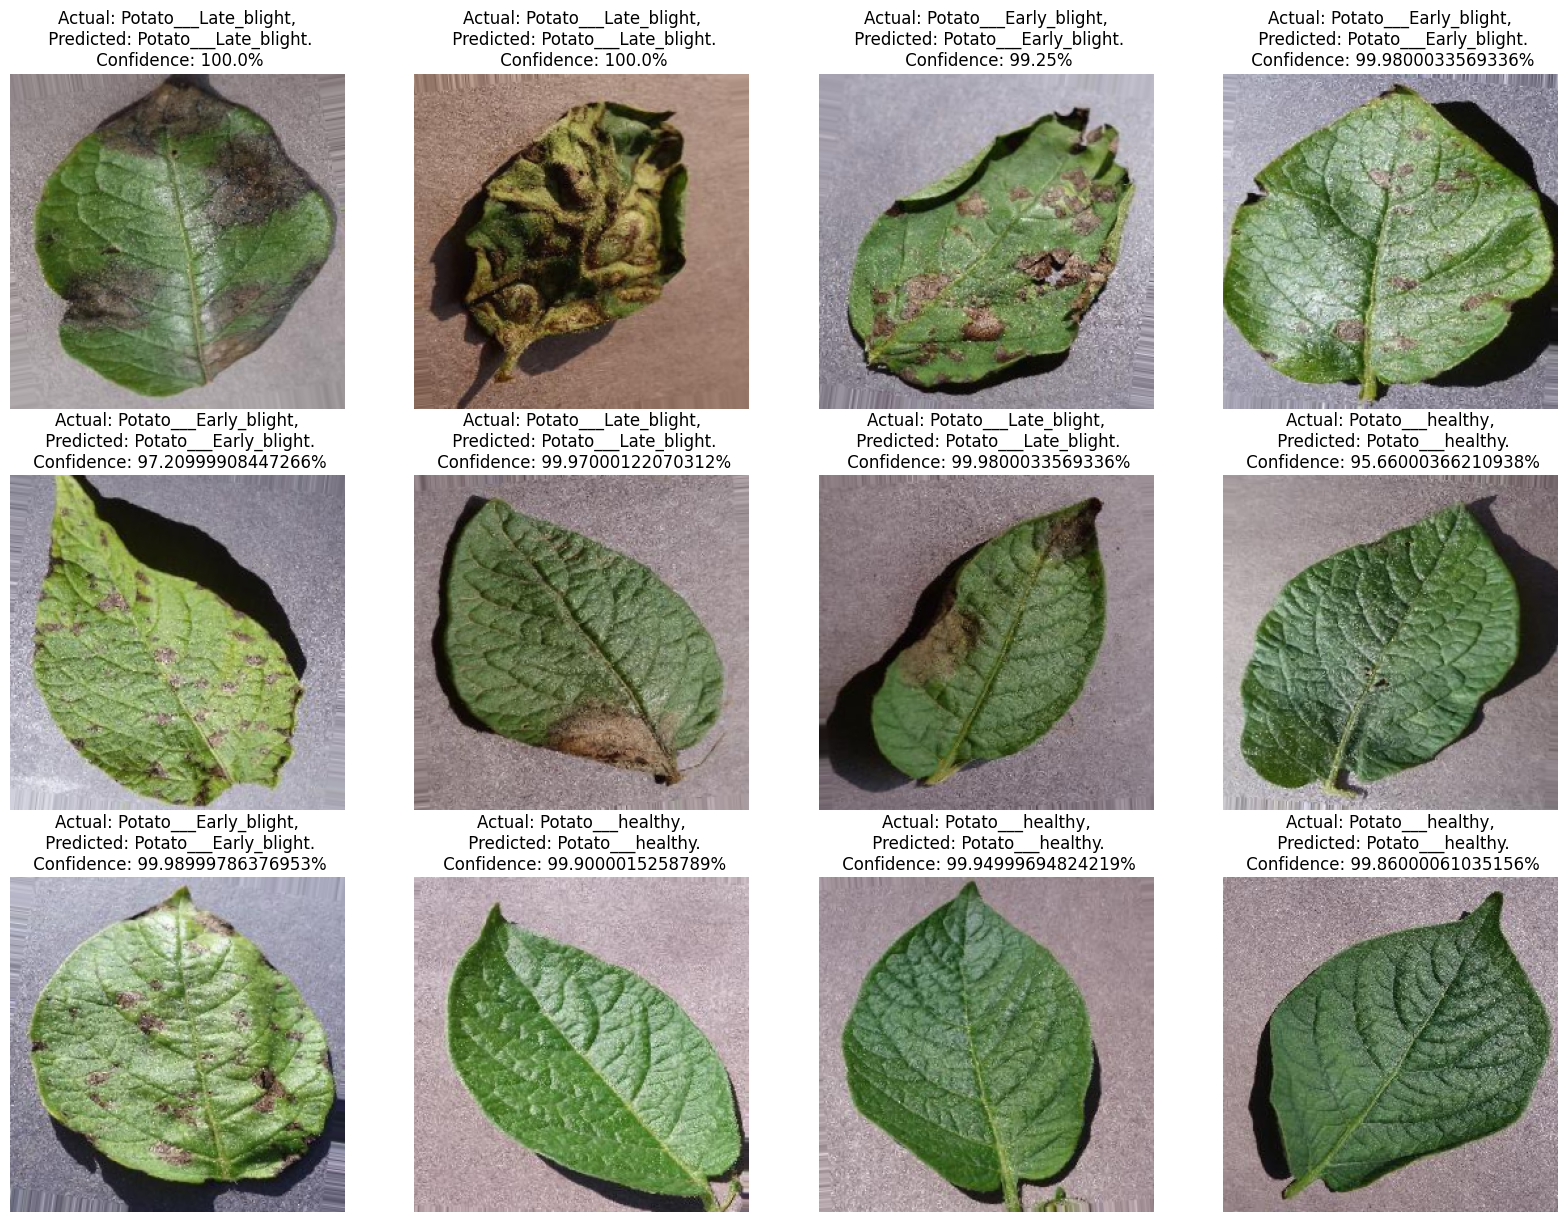

In [28]:
plt.figure(figsize=(20, 20))
for images, labels in test_generator:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Saving the model in h5 format

In [29]:
model.save("potatoes.h5")